In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeaturePreprocessor(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, embed_dim):
        super().__init__()
        self.node_encoder = nn.Sequential(
            nn.Linear(node_feat_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_feat_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, node_feat, real_edge_attrs):
        node_embed = self.node_encoder(node_feat.squeeze(0)).unsqueeze(0)  # [1, N, D]
        edge_embed = self.edge_encoder(real_edge_attrs.squeeze(0)).unsqueeze(0)  # [1, E, D]
        return node_embed, edge_embed

class VirtualEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = nn.Linear(embed_dim, 3*embed_dim)
        self.edge_weight_net = nn.Sequential(
            nn.Linear(2*embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, 1)
        )
        
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 2*embed_dim),
            nn.GELU(),
            nn.Linear(2*embed_dim, embed_dim)
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, virtual_edge_index):
        x = x.squeeze(0)  # [N, D]
        src, dst = virtual_edge_index
        
        # Project to Q/K/V
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(-1, self.num_heads, self.head_dim), qkv)
        
        # Compute edge weights (Eq.7)
        edge_feat = torch.cat([x[src], x[dst]], dim=-1)
        beta = self.edge_weight_net(edge_feat)  # [E, 1]
        
        # Compute attention scores
        attn_scores = (q[src] * k[dst]).sum(-1) / self.head_dim**0.5  # [E, H]
        attn_scores = attn_scores + beta
        attn = F.softmax(attn_scores, dim=0)  # [E, H]
        
        # Aggregate messages
        messages = (attn.unsqueeze(-1) * v[dst])  # [E, H, d]
        messages = messages.view(-1, self.embed_dim)  # [E, D]
        out = torch.zeros_like(x)
        out.index_add_(0, src, messages)  # [N, D]
        
        # FFN + residual
        out = self.norm(x + self.ffn(out)).unsqueeze(0)  # [1, N, D]
        return out

class RealEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, edge_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = nn.Linear(embed_dim, 3*embed_dim)
        self.edge_proj = nn.Linear(edge_dim, num_heads)
        
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 2*embed_dim),
            nn.GELU(),
            nn.Linear(2*embed_dim, embed_dim)
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, real_edge_index, edge_attrs):
        x = x.squeeze(0)  # [N, D]
        src, dst = real_edge_index
        
        # Project to Q/K/V
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(-1, self.num_heads, self.head_dim), qkv)
        
        # Edge projections (sum over P in Eq.9)
        edge_scores = self.edge_proj(edge_attrs.squeeze(0))  # [E, H]
        
        # Compute attention scores
        attn_scores = (q[src] * k[dst]).sum(-1) / self.head_dim**0.5  # [E, H]
        attn_scores = attn_scores + edge_scores
        attn = F.softmax(attn_scores, dim=0)  # [E, H]
        
        # Aggregate messages
        messages = (attn.unsqueeze(-1) * v[dst])  # [E, H, d]
        messages = messages.view(-1, self.embed_dim)  # [E, D]
        out = torch.zeros_like(x)
        out.index_add_(0, src, messages)  # [N, D]
        
        # FFN + residual
        out = self.norm(x + self.ffn(out)).unsqueeze(0)  # [1, N, D]
        return out

class HetGAT(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, embed_dim=64, num_heads=8):
        super().__init__()
        self.preprocessor = FeaturePreprocessor(node_feat_dim, edge_feat_dim, embed_dim)
        
        self.v_encoders = nn.ModuleList([
            VirtualEncoderLayer(embed_dim, num_heads)
            for _ in range(2)
        ])
        
        # Используем embed_dim вместо edge_feat_dim
        self.r_encoders = nn.ModuleList([
            RealEncoderLayer(embed_dim, num_heads, edge_dim=embed_dim)  # Третий аргумент
            for _ in range(2)
        ])
        
        self.predictor = nn.Sequential(
            nn.Linear(2*embed_dim + edge_feat_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, 1)
        )

    def forward(self, node_feat, real_edge_index, virtual_edge_index, real_edge_attrs):
        # Preprocess features (batch=1)
        x, edge_emb = self.preprocessor(node_feat, real_edge_attrs)
        
        # Virtual encoding

        for encoder in self.v_encoders:
            x = encoder(x, virtual_edge_index) 
        # Real encoding
        for encoder in self.r_encoders:
            x = encoder(x, real_edge_index, edge_emb)
        
        
        # Edge prediction
        src, dst = real_edge_index
        h_src = x.squeeze(0)[src]  # [E, D]
        h_dst = x.squeeze(0)[dst]  # [E, D]
        edge_feat = torch.cat([h_src, h_dst, real_edge_attrs.squeeze(0)], dim=-1)
        alpha = self.predictor(edge_feat).squeeze(-1)  # [1, E]
        return alpha

In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from utility import CustomHeteroGraphDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from utility import prepare_scalers
from sklearn.preprocessing import MinMaxScaler

src = "data/data_sioux.csv"

df = pd.read_csv(src)

indices = list(range(len(df)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

node_scaler, edge_scaler, y_scaler = prepare_scalers(src, train_indices, n_nodes=24, scaler_type=MinMaxScaler)

train_dataset = CustomHeteroGraphDataset(src, train_indices, node_scaler, edge_scaler, y_scaler, 24)
test_dataset = CustomHeteroGraphDataset(src, test_indices, node_scaler, edge_scaler, y_scaler, 24)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda batch: Batch.from_data_list(batch))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda batch: Batch.from_data_list(batch))


c:\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
num_epochs = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HetGAT(24, 2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
mae_f = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()

train_losses = []
test_losses = []

for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    total_train_loss = 0
    total_train_batches = 0

    for i, data in enumerate(train_loader): 
        data = data.to(device)
        optimizer.zero_grad()
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)

        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        
        loss = loss_fn(pred_f, data['real'].y)

        if i == 0:
            print("Sample predictions:")
            print("True flow:", data['real'].y[:5])
            print("Pred flow:", pred_f[:5])

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_batches += 1
        
    avg_train_loss = total_train_loss / total_train_batches
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch}, avg train Loss: {avg_train_loss:.4f}')


    model.eval()
    total_loss = 0
    total_batches = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
            pred_f = pred_alpha * data['real'].edge_attr[:, 1]
            batch_mae = loss_fn(pred_f, data['real'].y)
            total_loss += batch_mae
            total_batches += 1

    mae_loss = total_loss / total_batches
    test_losses.append(mae_loss)
    print(f'Epoch {epoch}, Test MAE: {mae_loss:.4f}')


  0%|          | 0/40 [00:00<?, ?it/s]

Sample predictions:
True flow: tensor([0.1588, 0.2240, 0.1511, 0.1297, 0.2626], device='cuda:0')
Pred flow: tensor([0.4809, 0.3073, 0.3395, 0.0307, 0.2021], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 1, avg train Loss: 0.0035


  2%|▎         | 1/40 [03:04<2:00:07, 184.80s/it]

Epoch 1, Test MAE: 0.0019
Sample predictions:
True flow: tensor([0.1474, 0.2938, 0.1687, 0.1180, 0.2576], device='cuda:0')
Pred flow: tensor([0.1465, 0.2829, 0.1506, 0.1106, 0.2819], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 2, avg train Loss: 0.0017


  5%|▌         | 2/40 [06:10<1:57:24, 185.38s/it]

Epoch 2, Test MAE: 0.0016
Sample predictions:
True flow: tensor([0.1231, 0.2834, 0.1280, 0.1070, 0.2505], device='cuda:0')
Pred flow: tensor([0.1186, 0.2618, 0.1150, 0.1256, 0.2405], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 3, avg train Loss: 0.0014


  8%|▊         | 3/40 [09:22<1:56:07, 188.32s/it]

Epoch 3, Test MAE: 0.0013
Sample predictions:
True flow: tensor([0.2078, 0.2543, 0.1250, 0.1921, 0.3221], device='cuda:0')
Pred flow: tensor([0.1676, 0.1998, 0.1023, 0.1358, 0.3227], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 4, avg train Loss: 0.0012


 10%|█         | 4/40 [12:26<1:52:02, 186.73s/it]

Epoch 4, Test MAE: 0.0011
Sample predictions:
True flow: tensor([0.1309, 0.2635, 0.1328, 0.0982, 0.2513], device='cuda:0')
Pred flow: tensor([0.1448, 0.2658, 0.1477, 0.1023, 0.2613], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 5, avg train Loss: 0.0011


 12%|█▎        | 5/40 [15:29<1:48:10, 185.43s/it]

Epoch 5, Test MAE: 0.0010
Sample predictions:
True flow: tensor([0.1615, 0.2754, 0.1588, 0.1553, 0.2769], device='cuda:0')
Pred flow: tensor([0.1402, 0.3014, 0.1767, 0.1423, 0.2719], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 6, avg train Loss: 0.0010


 15%|█▌        | 6/40 [18:32<1:44:27, 184.33s/it]

Epoch 6, Test MAE: 0.0010
Sample predictions:
True flow: tensor([0.1529, 0.2135, 0.1145, 0.1338, 0.2661], device='cuda:0')
Pred flow: tensor([0.1735, 0.2413, 0.1132, 0.1275, 0.2972], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 7, avg train Loss: 0.0009


 18%|█▊        | 7/40 [21:35<1:41:09, 183.91s/it]

Epoch 7, Test MAE: 0.0009
Sample predictions:
True flow: tensor([0.0948, 0.2794, 0.1281, 0.0651, 0.2209], device='cuda:0')
Pred flow: tensor([0.1214, 0.2977, 0.1413, 0.0790, 0.2413], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 8, avg train Loss: 0.0009


 20%|██        | 8/40 [24:43<1:38:52, 185.40s/it]

Epoch 8, Test MAE: 0.0008
Sample predictions:
True flow: tensor([0.0797, 0.2576, 0.1623, 0.0586, 0.2040], device='cuda:0')
Pred flow: tensor([0.0984, 0.2692, 0.1532, 0.0665, 0.2396], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 9, avg train Loss: 0.0008


 22%|██▎       | 9/40 [27:46<1:35:17, 184.44s/it]

Epoch 9, Test MAE: 0.0009
Sample predictions:
True flow: tensor([0.0972, 0.2900, 0.1774, 0.0814, 0.2129], device='cuda:0')
Pred flow: tensor([0.1091, 0.2915, 0.1772, 0.0894, 0.2914], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 10, avg train Loss: 0.0008


 25%|██▌       | 10/40 [30:49<1:32:03, 184.11s/it]

Epoch 10, Test MAE: 0.0008
Sample predictions:
True flow: tensor([0.1379, 0.2754, 0.1015, 0.1198, 0.2599], device='cuda:0')
Pred flow: tensor([0.1416, 0.2627, 0.0884, 0.0748, 0.2887], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 11, avg train Loss: 0.0008


 28%|██▊       | 11/40 [33:51<1:28:39, 183.43s/it]

Epoch 11, Test MAE: 0.0008
Sample predictions:
True flow: tensor([0.0956, 0.3466, 0.1653, 0.0818, 0.2648], device='cuda:0')
Pred flow: tensor([0.1185, 0.3016, 0.1415, 0.1010, 0.2206], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 12, avg train Loss: 0.0007


 30%|███       | 12/40 [36:53<1:25:25, 183.04s/it]

Epoch 12, Test MAE: 0.0007
Sample predictions:
True flow: tensor([0.1362, 0.2074, 0.0826, 0.1518, 0.2143], device='cuda:0')
Pred flow: tensor([0.1617, 0.2452, 0.1154, 0.1616, 0.2712], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 13, avg train Loss: 0.0007


 32%|███▎      | 13/40 [39:54<1:22:06, 182.46s/it]

Epoch 13, Test MAE: 0.0007
Sample predictions:
True flow: tensor([0.1499, 0.2232, 0.1265, 0.1216, 0.2323], device='cuda:0')
Pred flow: tensor([0.1505, 0.2457, 0.1244, 0.1215, 0.2533], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 14, avg train Loss: 0.0007


 35%|███▌      | 14/40 [42:58<1:19:16, 182.93s/it]

Epoch 14, Test MAE: 0.0008
Sample predictions:
True flow: tensor([0.1394, 0.2431, 0.0951, 0.1062, 0.2813], device='cuda:0')
Pred flow: tensor([0.1738, 0.2729, 0.1364, 0.1638, 0.2740], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 15, avg train Loss: 0.0007


 38%|███▊      | 15/40 [45:59<1:15:59, 182.39s/it]

Epoch 15, Test MAE: 0.0007
Sample predictions:
True flow: tensor([0.1452, 0.2535, 0.1591, 0.1224, 0.2710], device='cuda:0')
Pred flow: tensor([0.1620, 0.2642, 0.1322, 0.1457, 0.2739], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 16, avg train Loss: 0.0006


 40%|████      | 16/40 [49:02<1:13:00, 182.51s/it]

Epoch 16, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.2058, 0.2403, 0.1207, 0.1803, 0.3149], device='cuda:0')
Pred flow: tensor([0.1935, 0.2420, 0.1271, 0.1758, 0.3145], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 17, avg train Loss: 0.0006


 42%|████▎     | 17/40 [52:05<1:10:01, 182.69s/it]

Epoch 17, Test MAE: 0.0007
Sample predictions:
True flow: tensor([0.1593, 0.2951, 0.1540, 0.1548, 0.2805], device='cuda:0')
Pred flow: tensor([0.1694, 0.2768, 0.1445, 0.1446, 0.2743], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 18, avg train Loss: 0.0006


 45%|████▌     | 18/40 [55:07<1:06:55, 182.52s/it]

Epoch 18, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.0958, 0.2364, 0.0935, 0.0803, 0.2101], device='cuda:0')
Pred flow: tensor([0.1301, 0.2343, 0.0961, 0.0969, 0.2829], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 19, avg train Loss: 0.0006


 48%|████▊     | 19/40 [58:08<1:03:41, 181.96s/it]

Epoch 19, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1436, 0.2402, 0.1331, 0.1237, 0.2426], device='cuda:0')
Pred flow: tensor([0.1614, 0.2728, 0.1374, 0.1169, 0.2627], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 20, avg train Loss: 0.0006


 50%|█████     | 20/40 [1:01:11<1:00:44, 182.24s/it]

Epoch 20, Test MAE: 0.0007
Sample predictions:
True flow: tensor([0.1388, 0.3273, 0.1589, 0.1061, 0.2323], device='cuda:0')
Pred flow: tensor([0.1299, 0.3244, 0.1467, 0.0878, 0.2362], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 21, avg train Loss: 0.0006


 52%|█████▎    | 21/40 [1:04:13<57:41, 182.18s/it]  

Epoch 21, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1788, 0.2472, 0.1427, 0.1495, 0.3296], device='cuda:0')
Pred flow: tensor([0.1902, 0.2230, 0.1329, 0.1714, 0.3346], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 22, avg train Loss: 0.0006


 55%|█████▌    | 22/40 [1:07:00<53:19, 177.76s/it]

Epoch 22, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1591, 0.2433, 0.1130, 0.1300, 0.3337], device='cuda:0')
Pred flow: tensor([0.1568, 0.2182, 0.0895, 0.1409, 0.3120], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 23, avg train Loss: 0.0006


 57%|█████▊    | 23/40 [1:09:47<49:23, 174.32s/it]

Epoch 23, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.2302, 0.2422, 0.0923, 0.2032, 0.3261], device='cuda:0')
Pred flow: tensor([0.2111, 0.2147, 0.0961, 0.1911, 0.3094], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 24, avg train Loss: 0.0006


 60%|██████    | 24/40 [1:12:34<45:56, 172.29s/it]

Epoch 24, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1824, 0.2636, 0.1504, 0.1747, 0.3095], device='cuda:0')
Pred flow: tensor([0.1727, 0.2712, 0.1565, 0.1587, 0.2745], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 25, avg train Loss: 0.0005


 62%|██████▎   | 25/40 [1:15:21<42:42, 170.82s/it]

Epoch 25, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1120, 0.3544, 0.2415, 0.0927, 0.2427], device='cuda:0')
Pred flow: tensor([0.1248, 0.3337, 0.2095, 0.1103, 0.2319], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 26, avg train Loss: 0.0005


 65%|██████▌   | 26/40 [1:18:09<39:38, 169.93s/it]

Epoch 26, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1517, 0.2450, 0.1182, 0.1363, 0.3120], device='cuda:0')
Pred flow: tensor([0.1426, 0.2422, 0.1259, 0.1244, 0.2859], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 27, avg train Loss: 0.0005


 68%|██████▊   | 27/40 [1:20:54<36:29, 168.46s/it]

Epoch 27, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.1545, 0.3267, 0.1991, 0.1357, 0.2706], device='cuda:0')
Pred flow: tensor([0.1451, 0.3056, 0.1947, 0.1384, 0.2316], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 28, avg train Loss: 0.0005


 70%|███████   | 28/40 [1:23:43<33:41, 168.43s/it]

Epoch 28, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.1362, 0.2623, 0.1196, 0.1263, 0.2435], device='cuda:0')
Pred flow: tensor([0.1379, 0.2877, 0.1293, 0.1281, 0.2474], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 29, avg train Loss: 0.0005


 72%|███████▎  | 29/40 [1:26:30<30:49, 168.14s/it]

Epoch 29, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1295, 0.1992, 0.0741, 0.1058, 0.2950], device='cuda:0')
Pred flow: tensor([0.1356, 0.2273, 0.1031, 0.1172, 0.2915], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 30, avg train Loss: 0.0005


 75%|███████▌  | 30/40 [1:29:16<27:54, 167.46s/it]

Epoch 30, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1986, 0.2228, 0.0988, 0.1692, 0.3151], device='cuda:0')
Pred flow: tensor([0.1967, 0.2443, 0.1262, 0.1585, 0.3305], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 31, avg train Loss: 0.0005


 78%|███████▊  | 31/40 [1:32:04<25:08, 167.66s/it]

Epoch 31, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.1768, 0.2935, 0.1366, 0.1462, 0.3367], device='cuda:0')
Pred flow: tensor([0.1599, 0.2863, 0.1625, 0.1366, 0.3010], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 32, avg train Loss: 0.0005


 80%|████████  | 32/40 [1:34:52<22:20, 167.60s/it]

Epoch 32, Test MAE: 0.0006
Sample predictions:
True flow: tensor([0.1204, 0.2586, 0.1233, 0.1437, 0.2316], device='cuda:0')
Pred flow: tensor([0.1341, 0.2841, 0.1650, 0.1316, 0.2526], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 33, avg train Loss: 0.0005


 82%|████████▎ | 33/40 [1:37:41<19:36, 168.00s/it]

Epoch 33, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.0949, 0.2771, 0.1659, 0.0743, 0.2448], device='cuda:0')
Pred flow: tensor([0.1234, 0.2853, 0.1726, 0.0870, 0.2552], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 34, avg train Loss: 0.0005


 85%|████████▌ | 34/40 [1:40:27<16:45, 167.60s/it]

Epoch 34, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.1078, 0.2337, 0.1331, 0.0905, 0.2096], device='cuda:0')
Pred flow: tensor([0.0993, 0.2671, 0.1426, 0.0689, 0.2371], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 35, avg train Loss: 0.0005


 88%|████████▊ | 35/40 [1:43:16<14:00, 168.07s/it]

Epoch 35, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.0681, 0.2273, 0.1244, 0.0418, 0.2206], device='cuda:0')
Pred flow: tensor([0.0696, 0.2522, 0.1315, 0.0479, 0.2264], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 36, avg train Loss: 0.0005


 90%|█████████ | 36/40 [1:46:06<11:14, 168.67s/it]

Epoch 36, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.1775, 0.2890, 0.1610, 0.1589, 0.2751], device='cuda:0')
Pred flow: tensor([0.1480, 0.2909, 0.1753, 0.1408, 0.2587], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 37, avg train Loss: 0.0005


 92%|█████████▎| 37/40 [1:48:54<08:24, 168.26s/it]

Epoch 37, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.1228, 0.3113, 0.1455, 0.1107, 0.2458], device='cuda:0')
Pred flow: tensor([0.1048, 0.2909, 0.1603, 0.1007, 0.2348], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 38, avg train Loss: 0.0005


 95%|█████████▌| 38/40 [1:51:43<05:37, 168.69s/it]

Epoch 38, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.1433, 0.3542, 0.2216, 0.1114, 0.2651], device='cuda:0')
Pred flow: tensor([0.1192, 0.3421, 0.2160, 0.1037, 0.2605], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 39, avg train Loss: 0.0005


 98%|█████████▊| 39/40 [1:54:33<02:48, 168.87s/it]

Epoch 39, Test MAE: 0.0005
Sample predictions:
True flow: tensor([0.0777, 0.2934, 0.1599, 0.0911, 0.2068], device='cuda:0')
Pred flow: tensor([0.1235, 0.3210, 0.1649, 0.0938, 0.2509], device='cuda:0',
       grad_fn=<SliceBackward0>)
Epoch 40, avg train Loss: 0.0005


100%|██████████| 40/40 [1:57:21<00:00, 176.04s/it]

Epoch 40, Test MAE: 0.0005


In [1]:
import json

model = 'hgnn'

with open(f'loss/{model}_test_loss.json', "r") as f:
    test_losses = json.load(f)

with open(f'loss/{model}_train_loss.json', "r") as f:
    train_losses = json.load(f)

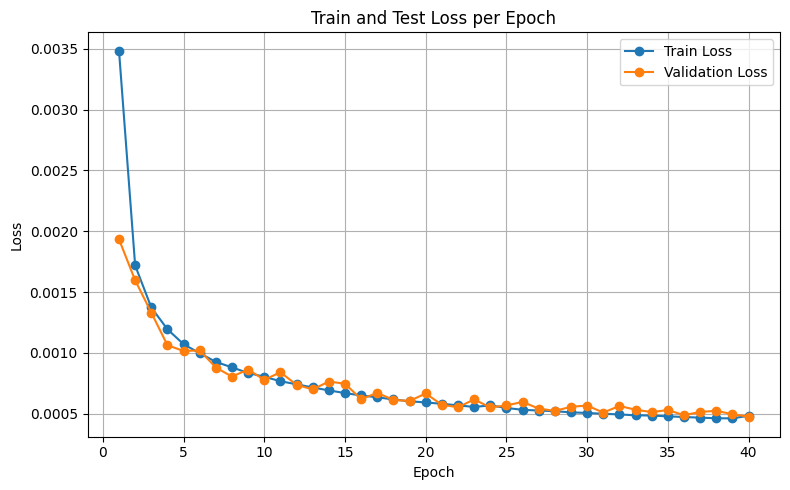

In [ ]:
from matplotlib import pyplot as plt


epochs = range(1, len(train_losses) + 1)

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import os


notebook_name = "hgnn"  # <-- измени на уникальное имя

# Создание папки, если её ещё нет
os.makedirs("loss", exist_ok=True)

# Сохраняем train_loss, test_loss и loss (если они существуют)
if 'train_losses' in globals():
    with open(f"loss/{notebook_name}_train_loss.json", "w") as f:
        json.dump(train_losses, f)

if 'test_losses' in globals():
    with open(f"loss/{notebook_name}_test_loss.json", "w") as f:
        json.dump([float(loss) for loss in test_losses], f)

In [24]:
import time


total_loss = 0
total_batches = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        start = time.time()
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        end = time.time()
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        
        print(end - start)
        batch_mae = mae_f(scaled_f, scaled_y)
        total_loss += batch_mae
        total_batches += 1
        break
print(total_loss / total_batches)

0.0033240318298339844


NameError: name 'mae_f' is not defined

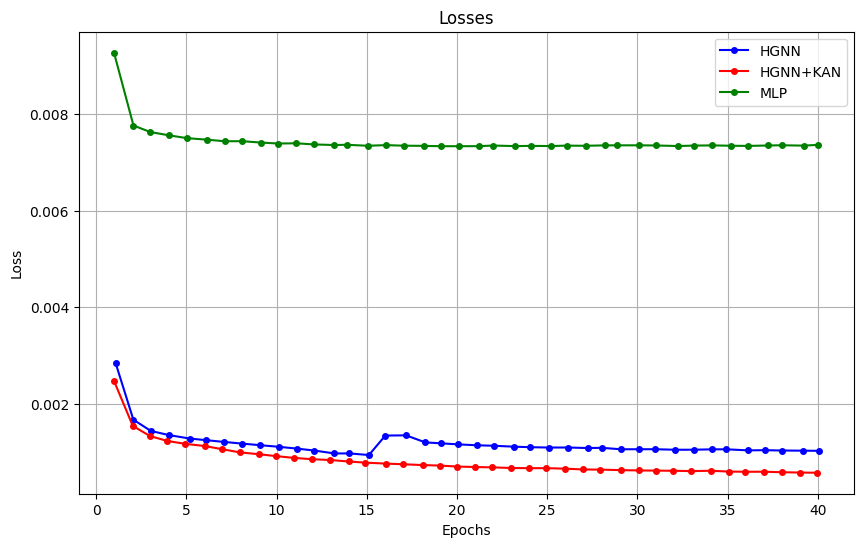

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data for first graph
x1 = [1.0823415108088428, 2.0668522635974664, 3.0352945572765835, 4.041404308589152, 5.186823863530203, 
      6.08972179144635, 7.0968031240073985, 8.06920647969956, 9.076362549279725, 10.118271332747895, 
      11.125352665308945, 12.097606546962876, 13.208497599073262, 14.04256273238542, 15.119224229741594, 
      16.030791651874967, 17.177705947198298, 18.252125333981052, 19.12056949608565, 20.05844434894714, 
      21.100652080491773, 22.073503858298615, 23.150464303731244, 24.053810653762078, 25.09624259636405, 
      26.138824013004243, 27.25068664636311, 28.015321088918366, 29.092057323293663, 30.099886026045855, 
      30.968703873246017, 32.08056650660489, 33.15790063713309, 34.13112610003551, 34.930438519459656, 
      36.14633508342521, 37.0499803815325, 38.02290689635844, 39.16967171764355, 40.0384148278246]
y1 = [0.0028487986024177425, 0.0016750681975299412, 0.001442190448608957, 0.0013561046131425046, 
      0.0012851380766428129, 0.0012516918592701928, 0.001214531212047607, 0.0011811176921208495, 
      0.0011477205209170231, 0.0011143396984361277, 0.0010771790512135422, 0.0010362385792492663, 
      0.0009765461220829206, 0.0009769384914332692, 0.0009435740176753043, 0.0013466910184787276, 
      0.0013509940023542157, 0.001204725248033482, 0.0011863165860129666, 0.0011641771454195546, 
      0.001145850227013695, 0.0011350175631994913, 0.0011167069935165632, 0.001105841632256497, 
      0.0010988051419069142, 0.00109929560359485, 0.001088528334672371, 0.0010926514825956163, 
      0.0010630504848564114, 0.0010635245978214158, 0.0010639333158946954, 0.0010531660469722164, 
      0.0010536728573830832, 0.001061657573662674, 0.0010620335942900915, 0.0010400249434801287, 
      0.0010442134862950984, 0.0010371442984996536, 0.0010339203303376238, 0.0010305655723921447]

# Data for second graph
x2 = [1.002751851579661, 2.035009213667257, 2.9795121791888164, 3.9529762731056177, 4.92491609710688, 
      6.025874481816276, 6.96569576116868, 7.970298511931494, 9.006257672385399, 9.97765311427397, 
      10.981275977233938, 11.984572210926292, 12.987541815351033, 13.99094692546592, 14.929461687747864, 
      16.061885358570887, 17.03240978907915, 18.10005198849176, 19.038131245083544, 20.008873428436882, 
      21.01162528001655, 21.949595660185796, 23.01712898317587, 23.987326784416513, 24.925079411740686, 
      25.99250385830822, 26.99547346273296, 27.93333496647967, 29.065432008035074, 30.10041128068614, 
      31.005936486938914, 31.97613428817955, 32.978777263336674, 34.07799362528546, 35.08096322971019, 
      35.95415213846903, 37.021249955768944, 38.02400180734861, 39.026644782505734, 39.964506286252444]
y2 = [0.0024696969696969702, 0.0015471380471380476, 0.0013383838383838385, 0.0012340067340067342, 
      0.001176767676767677, 0.00112962962962963, 0.001065656565656566, 0.0009983164983164987, 
      0.0009612794612794617, 0.0009208754208754211, 0.0008838383838383841, 0.0008569023569023572, 
      0.0008400673400673405, 0.00080976430976431, 0.0007861952861952864, 0.0007659932659932664, 
      0.0007525252525252529, 0.0007356902356902362, 0.0007255892255892257, 0.0007053872053872055, 
      0.0006952861952861955, 0.0006885521885521889, 0.0006750841750841753, 0.0006717171717171722, 
      0.0006717171717171722, 0.0006616161616161621, 0.0006447811447811451, 0.0006414141414141416, 
      0.0006313131313131315, 0.0006245791245791249, 0.0006212121212121214, 0.0006178451178451179, 
      0.0006111111111111113, 0.0006178451178451179, 0.0006010101010101012, 0.0005976430976430977, 
      0.0005976430976430977, 0.0005875420875420877, 0.0005808080808080811, 0.0005774410774410776]

# Data for third graph
x3 = [0.9938366718027751, 2.072769295419528, 3.0102255217817646, 4.058429051687913, 5.031604566465893, 
      6.153785544193866, 7.126435775318672, 8.09838562823925, 9.14571368539011, 10.080718588037541, 
      11.089963580333382, 12.099821403557922, 13.184181958257458, 13.894365457346968, 15.053666479899146, 
      16.06273637764393, 17.07233155904188, 18.15651701919036, 19.128641966661995, 20.100591819582576, 
      21.22207241910632, 22.006846196946352, 23.203354811598263, 24.100451743941722, 25.184637204090212, 
      26.081646589158144, 27.128449362655832, 28.212372180977727, 28.88526054069197, 30.0815065135173, 
      31.016161227062614, 32.250052528365316, 33.10967922678246, 34.156306905729096, 35.165814539851525, 
      36.137851940047625, 37.25915744502031, 38.006723630760604, 39.24052738478778, 40.025213615352286]
y3 = [0.00927170953564925, 0.0077641760925899975, 0.007629506496007844, 0.007560478752276228, 
      0.007503699966732035, 0.007471602946841294, 0.007439414002311247, 0.007440011512466731, 
      0.007411966837092028, 0.00739204983190923, 0.007396768630060231, 0.007372799280361394, 
      0.007361170813489283, 0.007365705762361675, 0.007345926644137833, 0.007358842055960217, 
      0.007347167626768454, 0.007343735773567726, 0.007336136670051827, 0.007336734180207311, 
      0.0073374236150021005, 0.007350201139865526, 0.007338641616472894, 0.007343291471144417, 
      0.007339859617943688, 0.007348607779450903, 0.007345152945090349, 0.007354016012396693, 
      0.007354429673273566, 0.007355165070388008, 0.0073516412925479745, 0.0073401047503151694, 
      0.007348829930662557, 0.0073535717099733845, 0.007345995587617312, 0.007342494790937105, 
      0.007351380839403277, 0.007355938769435494, 0.0073485005340383795, 0.0073653763657374974]

# Create a single figure
plt.figure(figsize=(10, 6))

# Plot all three datasets with lines and markers
plt.plot(x1, y1, 'b-o', label='HGNN', markersize=4)
plt.plot(x2, y2, 'r-o', label='HGNN+KAN', markersize=4)
plt.plot(x3, y3, 'g-o', label='MLP', markersize=4)

# Customize the plot
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show plot
plt.show()

In [5]:
total_loss = 0
total_batches = 0
from sklearn.metrics import mean_absolute_percentage_error

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        
        mask = scaled_y > 0
        if mask.any():
            batch_mape = mean_absolute_percentage_error(scaled_f[mask], scaled_y[mask])
            total_loss += batch_mape
            total_batches += 1
            
print(total_loss / total_batches if total_batches > 0 else 0)

0.24135767232626676


In [6]:
total_loss = 0
total_batches = 0
from sklearn.metrics import mean_absolute_percentage_error

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]
        scaled_f = y_scaler.inverse_transform([pred_f.cpu()])
        scaled_y = y_scaler.inverse_transform([data['real'].y.cpu()])
        scaled_f = torch.tensor(scaled_f, dtype=torch.float32)
        scaled_y = torch.tensor(scaled_y, dtype=torch.float32)
        batch_mape = mean_absolute_percentage_error(scaled_f, scaled_y)
        total_loss += batch_mape
        total_batches += 1
print(total_loss / total_batches)

0.26850813189148903


In [7]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

total_r2 = 0
total_batches = 0
true_values = []
pred_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное преобразование с помощью scaler'а
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Вычисление R^2
        batch_r2 = r2_score(scaled_y, scaled_f)
        total_r2 += batch_r2
        total_batches += 1

        # Добавляем в список для графика
        true_values.extend(scaled_y)
        pred_values.extend(scaled_f)

# Вычисляем средний R^2
avg_r2 = total_r2 / total_batches
print(f"Средний R²: {avg_r2:.4f}")

# Построение графика

Средний R²: 0.9851


In [8]:
import torch
from sklearn.metrics import mean_absolute_percentage_error

total_loss = 0
total_batches = 0

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        # Предсказания модели
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное масштабирование
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Фильтрация ненулевых значений
        mask = scaled_y > 0
        if mask.sum() > 0:  # Проверка, есть ли ненулевые значения
            batch_mape = mean_absolute_percentage_error(scaled_y[mask], scaled_f[mask])
            total_loss += batch_mape
            total_batches += 1

# Усреднение MAPE по всем батчам
final_mape = total_loss / total_batches if total_batches > 0 else 0
print(f"Средний MAPE (без учета нулей): {final_mape:.4f}")


Средний MAPE (без учета нулей): 0.6924


In [9]:
from sklearn.metrics import mean_squared_error

total_loss = 0
total_batches = 0
true_values = []
pred_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred_alpha = model(data['real'].x, data['real'].edge_index, data['virtual'].edge_index, data['real'].edge_attr)
        pred_f = pred_alpha * data['real'].edge_attr[:, 1]

        # Обратное преобразование через scaler
        scaled_f = y_scaler.inverse_transform(pred_f.cpu().numpy().reshape(-1, 1)).flatten()
        scaled_y = y_scaler.inverse_transform(data['real'].y.cpu().numpy().reshape(-1, 1)).flatten()

        # Сохраняем для MSE и графика
        true_values.extend(scaled_y)
        pred_values.extend(scaled_f)

# Вычисляем MSE
mse = mean_squared_error(true_values, pred_values)
print(f"MSE: {mse:.4f}")

MSE: 27157.3125


In [ ]:
import pickle
import json
import torch

model_name = "kan_v2"

# Загрузка скейлеров
with open(f"scalers/node_scaler_{model_name}.pkl", "rb") as f:
    node_scaler = pickle.load(f)

with open(f"scalers/edge_scaler_{model_name}.pkl", "rb") as f:
    edge_scaler = pickle.load(f)

with open(f"scalers/y_scaler_{model_name}.pkl", "rb") as f:
    y_scaler = pickle.load(f)

# Загрузка модели
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HetGAT(24, 2).to(device)  # Создай экземпляр модели
model.load_state_dict(torch.load(f"models/hetgat_model_{model_name}.pth"))
model.eval()  # Перевод в режим оценки (если требуется)

# Загрузка индексов
with open(f"indices/train_indices_{model_name}.json", "r") as f:
    train_indices = json.load(f)

with open(f"indices/test_indices_{model_name}.json", "r") as f:
    test_indices = json.load(f)

# Теперь все данные загружены и готовы к использованию